# Semi-supervised image classification using contrastive pretraining with SimCLR

**Author:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)<br>
**Date created:** 2021/04/24<br>
**Last modified:** 2021/04/24<br>
**Description:** Contrastive pretraining with SimCLR for semi-supervised image classification on the STL-10 dataset.

## Introduction

### Semi-supervised learning

Semi-supervised learning is a machine learning paradigm that deals with
**partially labeled datasets**. When applying deep learning in the real world,
one usually has to gather a large dataset to make it work well. However, while
the cost of labeling scales linearly with the dataset size (labeling each
example takes a constant time), model performance only scales
[sublinearly](https://arxiv.org/abs/2001.08361) with it. This means that
labeling more and more samples becomes less and less cost-efficient, while
gathering unlabeled data is generally cheap, as it is usually readily available
in large quantities.

Semi-supervised learning offers to solve this problem by only requiring a
partially labeled dataset, and by being label-efficient by utilizing the
unlabeled examples for learning as well.

In this example, we will pretrain an encoder with contrastive learning on the
[STL-10](https://ai.stanford.edu/~acoates/stl10/) semi-supervised dataset using
no labels at all, and then fine-tune it using only its labeled subset.

### Contrastive learning

On the highest level, the main idea behind contrastive learning is to **learn
representations that are invariant to image augmentations** in a self-supervised
manner. One problem with this objective is that it has a trivial degenerate
solution: the case where the representations are constant, and do not depend at all on the
input images.

Contrastive learning avoids this trap by modifying the objective in the
following way: it pulls representations of augmented versions/views of the same
image closer to each other (contracting positives), while simultaneously pushing
different images away from each other (contrasting negatives) in representation
space.

One such contrastive approach is [SimCLR](https://arxiv.org/abs/2002.05709),
which essentially identifies the core components needed to optimize this
objective, and can achieve high performance by scaling this simple approach.

Another approach is [SimSiam](https://arxiv.org/abs/2011.10566)
([Keras example](https://keras.io/examples/vision/simsiam/)),
whose main difference from
SimCLR is that the former does not use any negatives in its loss. Therefore, it does not
explicitly prevent the trivial solution, and, instead, avoids it implicitly by
architecture design (asymmetric encoding paths using a predictor network and
batch normalization (BatchNorm) are applied in the final layers).

For further reading about SimCLR, check out
[the official Google AI blog post](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html),
and for an overview of self-supervised learning across both vision and language
check out
[this blog post](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/).

## Setup

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

## Hyperparameter setup

In [2]:
# Dataset hyperparameters
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_size = 96
image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
batch_size = 525  # Corresponds to 200 steps per epoch
width = 128
temperature = 0.1
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

## Dataset

During training we will simultaneously load a large batch of unlabeled images along with a
smaller batch of labeled images.

In [3]:

def prepare_dataset():
    # Labeled and unlabeled samples are loaded synchronously
    # with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    unlabeled_train_dataset = (
        tfds.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size)
    )
    labeled_train_dataset = (
        tfds.load("stl10", split="train", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size)
    )
    test_dataset = (
        tfds.load("stl10", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

batch size is 500 (unlabeled) + 25 (labeled)


## Image augmentations

The two most important image augmentations for contrastive learning are the
following:

- Cropping: forces the model to encode different parts of the same image
similarly, we implement it with the
[RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_translation/)
and
[RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_zoom/)
layers
- Color jitter: prevents a trivial color histogram-based solution to the task by
distorting color histograms. A principled way to implement that is by affine
transformations in color space.

In this example we use random horizontal flips as well. Stronger augmentations
are applied for contrastive learning, along with weaker ones for supervised
classification to avoid overfitting on the few labeled examples.

We implement random color jitter as a custom preprocessing layer. Using
preprocessing layers for data augmentation has the following two advantages:

- The data augmentation will run on GPU in batches, so the training will not be
bottlenecked by the data pipeline in environments with constrained CPU
resources (such as a Colab Notebook, or a personal machine)
- Deployment is easier as the data preprocessing pipeline is encapsulated in the
model, and does not have to be reimplemented when deploying it

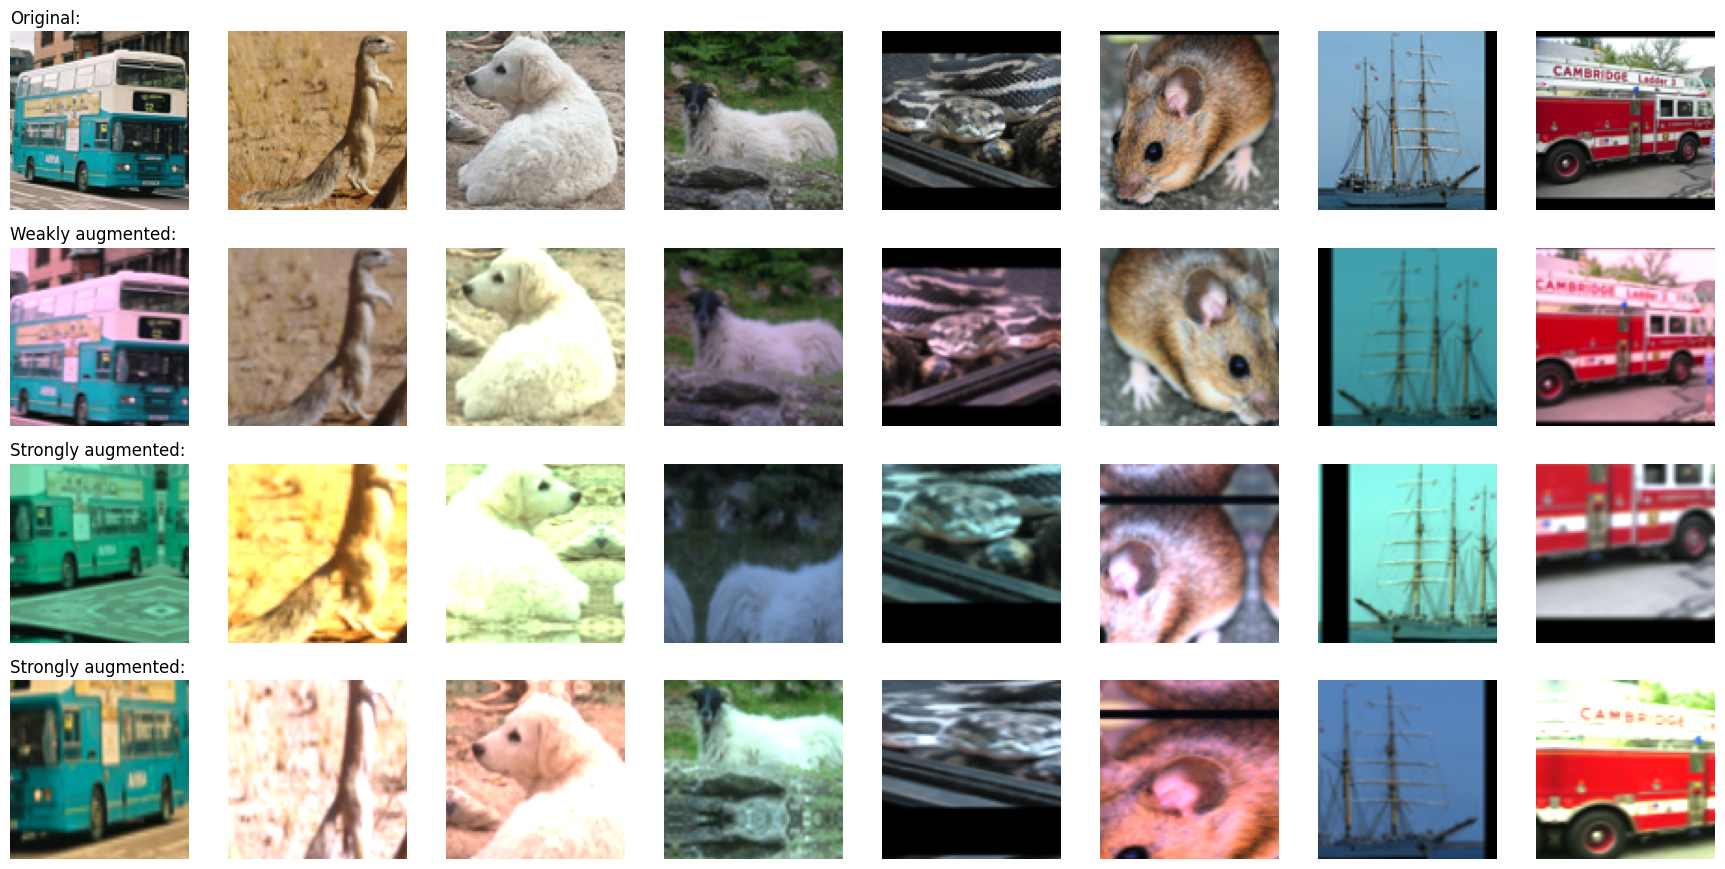

In [4]:

# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

## Encoder architecture

In [5]:

# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )


## Supervised baseline model

A baseline supervised model is trained using random initialization.

In [ ]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(10),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 [==============================] - 13s 61ms/step - loss: 1.9912 - acc: 0.2446 - val_loss: 1.7034 - val_acc: 0.3525
Epoch 2/20
200/200 [==============================] - 12s 60ms/step - loss: 1.7255 - acc: 0.3404 - val_loss: 1.5996 - val_acc: 0.3730
Epoch 3/20
200/200 [==============================] - 12s 60ms/step - loss: 1.6041 - acc: 0.3956 - val_loss: 1.4454 - val_acc: 0.4444
Epoch 4/20
200/200 [==============================] - 12s 59ms/step - loss: 1.5267 - acc: 0.4258 - val_loss: 1.5017 - val_acc: 0.4369
Epoch 5/20
200/200 [==============================] - 12s 59ms/step - loss: 1.4343 - acc: 0.4576 - val_loss: 1.3492 - val_acc: 0.4904
Epoch 6/20
200/200 [==============================] - 12s 59ms/step - loss: 1.3855 - acc: 0.4818 - val_loss: 1.3150 - val_acc: 0.5104
Epoch 7/20
200/200 [==============================] - 12s 60ms/step - loss: 1.3268 - acc: 0.5078 - val_loss: 1.3244 - val_acc: 0.5071
Epoch 8/20
200/200 [==============================] - 12s 59ms

## Self-supervised model for contrastive pretraining

We pretrain an encoder on unlabeled images with a contrastive loss.
A nonlinear projection head is attached to the top of the encoder, as it
improves the quality of representations of the encoder.

We use the InfoNCE/NT-Xent/N-pairs loss, which can be interpreted in the
following way:

1. We treat each image in the batch as if it had its own class.
2. Then, we have two examples (a pair of augmented views) for each "class".
3. Each view's representation is compared to every possible pair's one (for both
  augmented versions).
4. We use the temperature-scaled cosine similarity of compared representations as
  logits.
5. Finally, we use categorical cross-entropy as the "classification" loss

The following two metrics are used for monitoring the pretraining performance:

- [Contrastive accuracy (SimCLR Table 5)](https://arxiv.org/abs/2002.05709):
Self-supervised metric, the ratio of cases in which the representation of an
image is more similar to its differently augmented version's one, than to the
representation of any other image in the current batch. Self-supervised
metrics can be used for hyperparameter tuning even in the case when there are
no labeled examples.
- [Linear probing accuracy](https://arxiv.org/abs/1603.08511): Linear probing is
a popular metric to evaluate self-supervised classifiers. It is computed as
the accuracy of a logistic regression classifier trained on top of the
encoder's features. In our case, this is done by training a single dense layer
on top of the frozen encoder. Note that contrary to traditional approach where
the classifier is trained after the pretraining phase, in this example we
train it during pretraining. This might slightly decrease its accuracy, but
that way we can monitor its value during training, which helps with
experimentation and debugging.

Another widely used supervised metric is the
[KNN accuracy](https://arxiv.org/abs/1805.01978), which is the accuracy of a KNN
classifier trained on top of the encoder's features, which is not implemented in
this example.

In [9]:

# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 47, 47, 128)       3584      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 128)       147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 128)       147584    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 128)         147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               409728    
Total params: 856,064
Trainable params: 856,064
Non-trainable params: 0
_____________________________________________________

## Supervised finetuning of the pretrained encoder

We then finetune the encoder on the labeled examples, by attaching
a single randomly initalized fully connected classification layer on its top.

In [10]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 [==============================] - 13s 59ms/step - loss: 1.7397 - acc: 0.3458 - val_loss: 1.4005 - val_acc: 0.4689
Epoch 2/20
200/200 [==============================] - 12s 59ms/step - loss: 1.4372 - acc: 0.4618 - val_loss: 1.2788 - val_acc: 0.5359
Epoch 3/20
200/200 [==============================] - 12s 58ms/step - loss: 1.2590 - acc: 0.5358 - val_loss: 1.2158 - val_acc: 0.5535
Epoch 4/20
200/200 [==============================] - 12s 58ms/step - loss: 1.1711 - acc: 0.5798 - val_loss: 1.1500 - val_acc: 0.5900
Epoch 5/20
200/200 [==============================] - 12s 58ms/step - loss: 1.1230 - acc: 0.5996 - val_loss: 1.1134 - val_acc: 0.5953
Epoch 6/20
200/200 [==============================] - 12s 59ms/step - loss: 1.0389 - acc: 0.6208 - val_loss: 1.2080 - val_acc: 0.5871
Epoch 7/20
200/200 [==============================] - 12s 58ms/step - loss: 0.9597 - acc: 0.6548 - val_loss: 1.1473 - val_acc: 0.5971
Epoch 8/20
200/200 [==============================] - 12s 58ms

## Comparison against the baseline

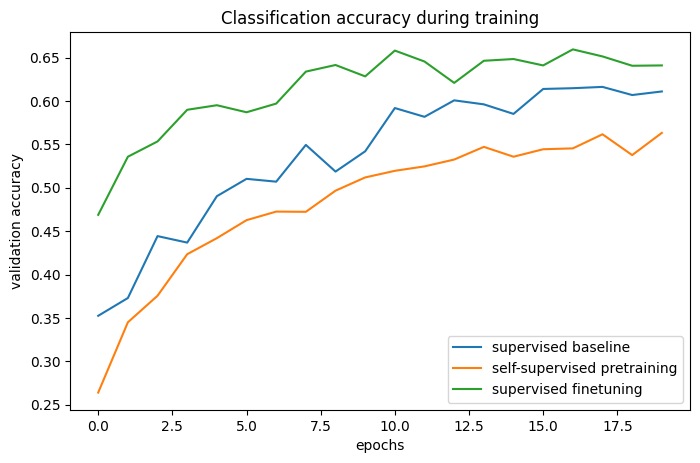

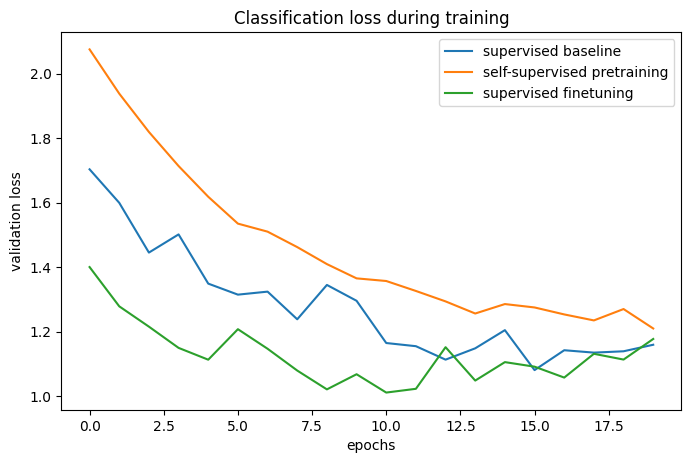

In [11]:

# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

By comparing the training curves, we can see that when using contrastive
pretraining, a higher validation accuracy can be reached, paired with a lower
validation loss, which means that the pretrained network was able to generalize
better when seeing only a small amount of labeled examples.

## Improving further

### Architecture

The experiment in the original paper demonstrated that increasing the width and depth of the
models improves performance at a higher rate than for supervised learning. Also,
using a [ResNet-50](https://keras.io/api/applications/resnet/#resnet50-function)
encoder is quite standard in the literature. However keep in mind, that more
powerful models will not only increase training time but will also require more
memory and will limit the maximal batch size you can use.

It has [been](https://arxiv.org/abs/1905.09272)
[reported](https://arxiv.org/abs/1911.05722) that the usage of BatchNorm layers
could sometimes degrade performance, as it introduces an intra-batch dependency
between samples, which is why I did not have used them in this example. In my
experiments however, using BatchNorm, especially in the projection head,
improves performance.

### Hyperparameters

The hyperparameters used in this example have been tuned manually for this task and
architecture. Therefore, without changing them, only marginal gains can be expected
from further hyperparameter tuning.

However for a different task or model architecture these would need tuning, so
here are my notes on the most important ones:

- **Batch size**: since the objective can be interpreted as a classification
over a batch of images (loosely speaking), the batch size is actually a more
important hyperparameter than usual. The higher, the better.
- **Temperature**: the temperature defines the "softness" of the softmax
distribution that is used in the cross-entropy loss, and is an important
hyperparameter. Lower values generally lead to a higher contrastive accuracy.
A recent trick (in [ALIGN](https://arxiv.org/abs/2102.05918)) is to learn
the temperature's value as well (which can be done by defining it as a
tf.Variable, and applying gradients on it). Even though this provides a good baseline
value, in my experiments the learned temperature was somewhat lower
than optimal, as it is optimized with respect to the contrastive loss, which is not a
perfect proxy for representation quality.
- **Image augmentation strength**: during pretraining stronger augmentations
increase the difficulty of the task, however after a point too strong
augmentations will degrade performance. During finetuning stronger
augmentations reduce overfitting while in my experience too strong
augmentations decrease the performance gains from pretraining. The whole data
augmentation pipeline can be seen as an important hyperparameter of the
algorithm, implementations of other custom image augmentation layers in Keras
can be found in
[this repository](https://github.com/beresandras/image-augmentation-layers-keras).
- **Learning rate schedule**: a constant schedule is used here, but it is
quite common in the literature to use a
[cosine decay schedule](https://www.tensorflow.org/api_docs/python/tf/keras/experimental/CosineDecay),
which can further improve performance.
- **Optimizer**: Adam is used in this example, as it provides good performance
with default parameters. SGD with momentum requires more tuning, however it
could slightly increase performance.

## Related works

Other instance-level (image-level) contrastive learning methods:

- [MoCo](https://arxiv.org/abs/1911.05722)
([v2](https://arxiv.org/abs/2003.04297),
[v3](https://arxiv.org/abs/2104.02057)): uses a momentum-encoder as well,
whose weights are an exponential moving average of the target encoder
- [SwAV](https://arxiv.org/abs/2006.09882): uses clustering instead of pairwise
comparison
- [BarlowTwins](https://arxiv.org/abs/2103.03230): uses a cross
correlation-based objective instead of pairwise comparison

Keras implementations of **MoCo** and **BarlowTwins** can be found in
[this repository](https://github.com/beresandras/contrastive-classification-keras),
which includes a Colab notebook.

There is also a new line of works, which optimize a similar objective, but
without the use of any negatives:

- [BYOL](https://arxiv.org/abs/2006.07733): momentum-encoder + no negatives
- [SimSiam](https://arxiv.org/abs/2011.10566)
([Keras example](https://keras.io/examples/vision/simsiam/)):
no momentum-encoder + no negatives

In my experience, these methods are more brittle (they can collapse to a constant
representation, I could not get them to work using this encoder architecture).
Even though they are generally more dependent on the
[model](https://generallyintelligent.ai/understanding-self-supervised-contrastive-learning.html)
[architecture](https://arxiv.org/abs/2010.10241), they can improve
performance at smaller batch sizes.